In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# assign path
path, dirs, files = next(os.walk("data/halfhourly_dataset/"))
file_count = len(files)
df_list = []

#blocks with problems: 51 12 33 13 19 108 9
files = ["block_0.csv", "block_1.csv", "block_2.csv"]
file_count = 3

# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv("data/halfhourly_dataset/"+files[i], low_memory=False)
    df_list.append(temp_df)
    
df = pd.concat(df_list)

#read weather file
df_weather = pd.read_csv("data/weather_daily_darksky.csv", low_memory=False)


In [3]:
#Remover Nulls
df = df.dropna()

In [4]:
df.columns = ['house', 'time', 'energy']

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime'], errors='coerce')

#We will work with only the year 2013 to make things easier
df = df[df['time'].dt.isocalendar().year == 2013]
df = df[df['time'].dt.strftime('%Y-%m-%d') != '2012-12-31']

df_weather = df_weather[df_weather['temperatureMaxTime'].dt.isocalendar().year == 2013]
df_weather = df_weather[df_weather['temperatureMaxTime'].dt.strftime('%Y-%m-%d') != '2012-12-31']

df['house'] = df['house'].astype(str)
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

In [5]:
#print(df.describe(include = 'all', datetime_is_numeric=True))


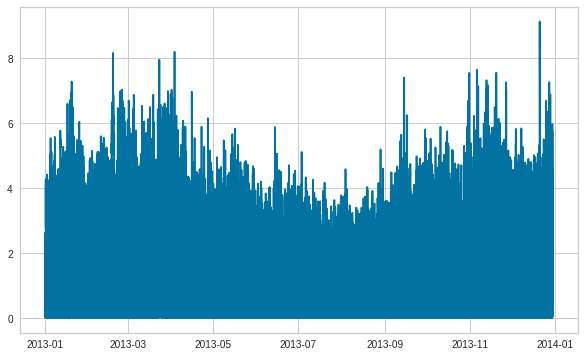

In [6]:
fig = plt.subplots(figsize =(10, 6))
plt.plot(df['time'], df['energy'])
plt.show()

In [7]:
# the hours and if it's night or day (7:00-22:00)
#df['hours'] = df['time'].dt.hour
df['daylight'] = ((df['time'].dt.hour >= 7) & (df['time'].dt.hour <= 22)).astype(int)

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['time'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [9]:
# creation of 4 distinct categories
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0] # WeekEnd Night
b = df.loc[df['categories'] == 1] # WeekEnd Day
c = df.loc[df['categories'] == 2] # WeekDay Night
d = df.loc[df['categories'] == 3] # WeekDay Day
#print(a)

a = a.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
b = b.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
c = c.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
d = d.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
#print(a)

a = a.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
b = b.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
c = c.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
d = d.groupby(['time'])['energy'].sum().reset_index().sort_values('time')
#print(a)

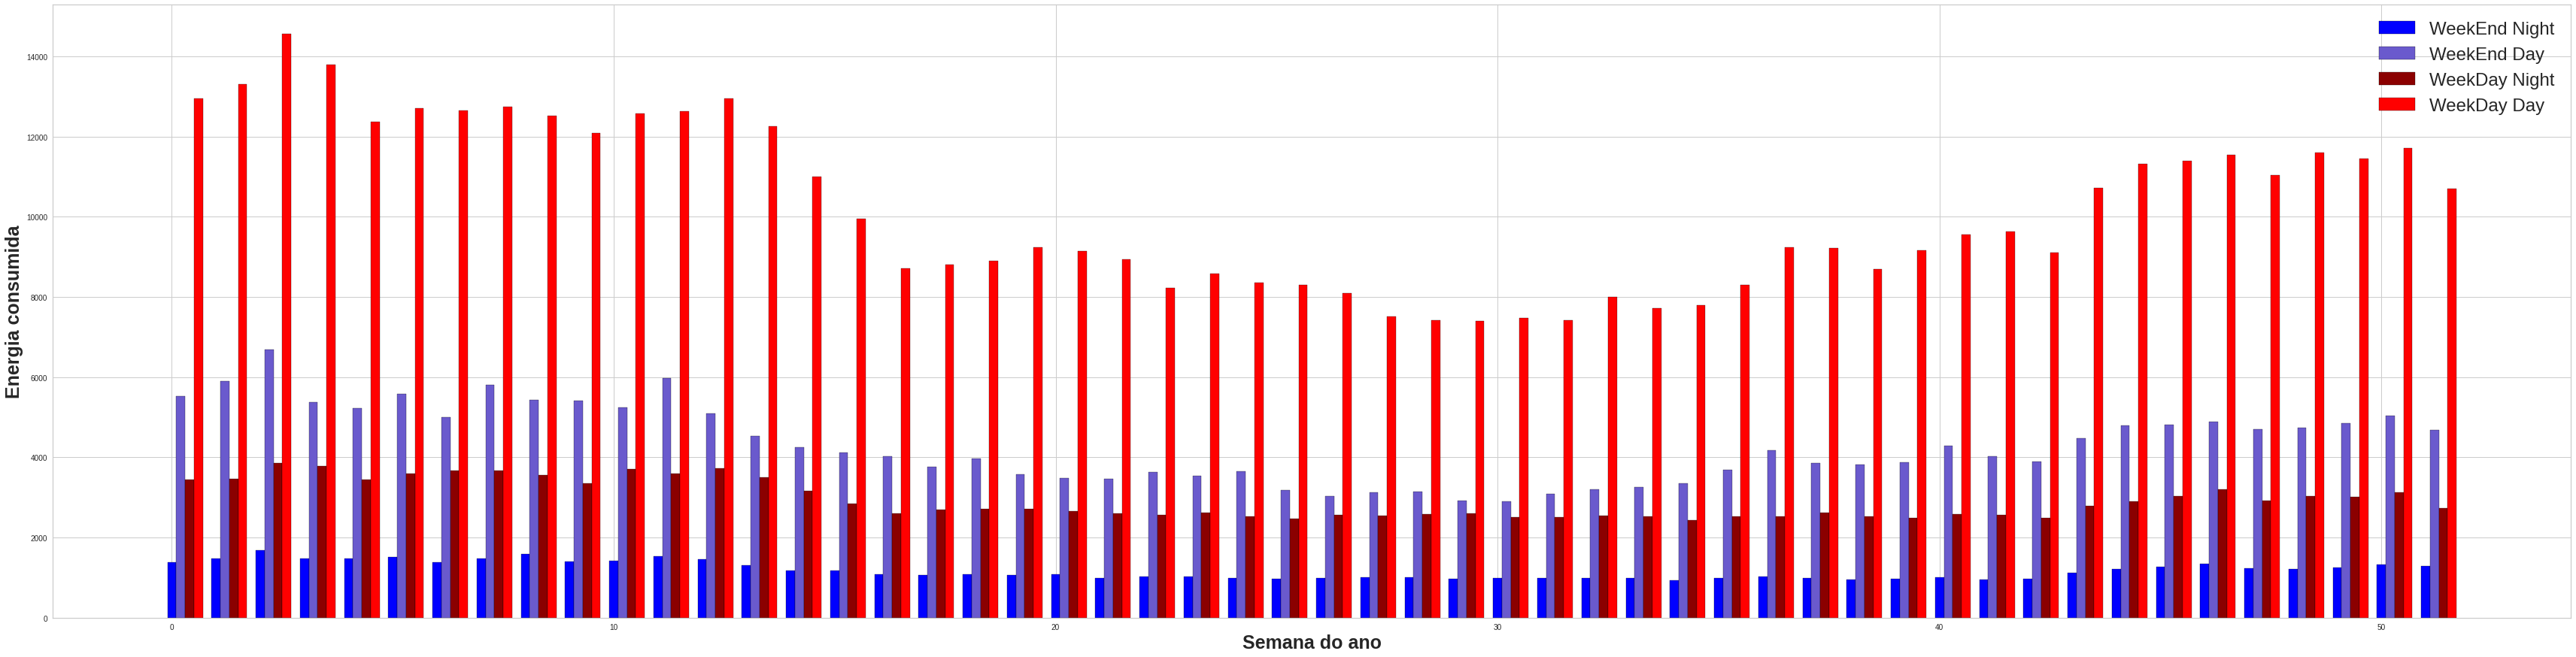

In [10]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(60, 15))

weeks = list(range(1, 52))
label=['WeekEnd Night', 'WeekEnd Day', 'WeekDay Night', 'WeekDay Day']
 
# Set position of bar on X axis
br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, a['energy'], color ='blue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Night')

plt.bar(br2, b['energy'], color ='slateblue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Day')

plt.bar(br3, c['energy'], color ='darkred', width = barWidth,
        edgecolor ='black', label ='WeekDay Night')

plt.bar(br4, d['energy'], color ='red', width = barWidth,
        edgecolor ='black', label ='WeekDay Day')
 
# Adding Xticks
plt.xlabel('Semana do ano', fontweight ='bold', fontsize = 25)
plt.ylabel('Energia consumida', fontweight ='bold', fontsize = 25)
#plt.xticks([r + barWidth for r in range(len(a))],
#        weeks)
 
plt.legend(loc='upper right', prop={'size': 24})
plt.show()
#lux mais cara durante o dia
#grafico preço e gasto depois

In [11]:
#usar temp média
dft = df.groupby(['house', pd.Grouper(key='time', freq='D')])['energy'].sum().reset_index().sort_values(['house', 'time'])
dft = dft.groupby(['time'])['energy'].sum().reset_index().sort_values('time')

#maybe fazer isto mais cedo?
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime']).dt.date
dft['time'] = pd.to_datetime(dft['time']).dt.date

dft = dft.merge((df_weather.iloc[:,[0,1]]), left_on='time', right_on='temperatureMaxTime')
dft = dft.iloc[:,[0,1,2]]
print(dft)

           time       energy  temperatureMax
0    2013-01-01  3420.095998            7.49
1    2013-01-02  3365.991000           10.82
2    2013-01-03  3148.651001           11.41
3    2013-01-04  3142.730999           10.79
4    2013-01-05  3356.867999           10.66
..          ...          ...             ...
358  2013-12-25  3642.939000            7.19
359  2013-12-26  3491.808999            7.64
360  2013-12-27  3168.927999           10.99
361  2013-12-28  2930.288002            7.81
362  2013-12-29  3046.942003            7.56

[363 rows x 3 columns]


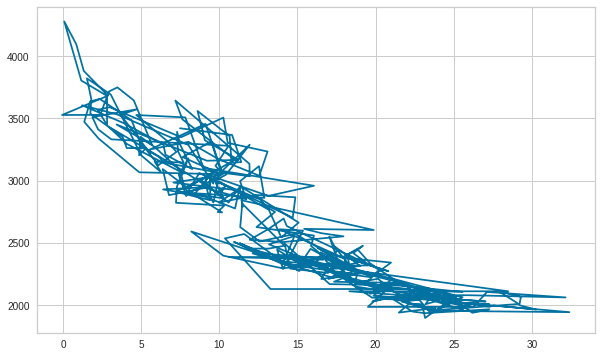

In [12]:
fig = plt.subplots(figsize =(10, 6))
plt.plot(dft['temperatureMax'], dft['energy'])
plt.show()
#mais frio mais energia se gasta

In [13]:
# time with int
data = dft
print(type(data['time'][0]))
data['time'] = pd.to_datetime(data['time'], errors='coerce')

data['time_int'] = data['time'].dt.year * 10000000000 + data['time'].dt.month * 100000000 + data['time'].dt.day * 1000000
print(data)

<class 'datetime.date'>
          time       energy  temperatureMax        time_int
0   2013-01-01  3420.095998            7.49  20130101000000
1   2013-01-02  3365.991000           10.82  20130102000000
2   2013-01-03  3148.651001           11.41  20130103000000
3   2013-01-04  3142.730999           10.79  20130104000000
4   2013-01-05  3356.867999           10.66  20130105000000
..         ...          ...             ...             ...
358 2013-12-25  3642.939000            7.19  20131225000000
359 2013-12-26  3491.808999            7.64  20131226000000
360 2013-12-27  3168.927999           10.99  20131227000000
361 2013-12-28  2930.288002            7.81  20131228000000
362 2013-12-29  3046.942003            7.56  20131229000000

[363 rows x 4 columns]


In [14]:
scaler = MinMaxScaler()
scaler.fit(data[['energy']])
data['energy'] = scaler.transform(data[['energy']])
scaler.fit(data[['time_int']])
data['time_int'] = scaler.transform(data[['time_int']])
print(data)

          time    energy  temperatureMax  time_int
0   2013-01-01  0.639780            7.49  0.000000
1   2013-01-02  0.617075           10.82  0.000887
2   2013-01-03  0.525869           11.41  0.001773
3   2013-01-04  0.523385           10.79  0.002660
4   2013-01-05  0.613247           10.66  0.003546
..         ...       ...             ...       ...
358 2013-12-25  0.733295            7.19  0.996454
359 2013-12-26  0.669874            7.64  0.997340
360 2013-12-27  0.534378           10.99  0.998227
361 2013-12-28  0.434234            7.81  0.999113
362 2013-12-29  0.483188            7.56  1.000000

[363 rows x 4 columns]


Text(0, 0.5, 'energy')

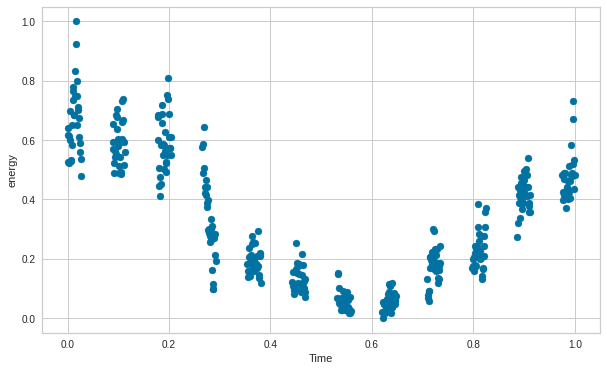

In [15]:
fig = plt.subplots(figsize =(10, 6))
plt.scatter(data['time_int'], data['energy'])
plt.xlabel('Time')
plt.ylabel('energy')

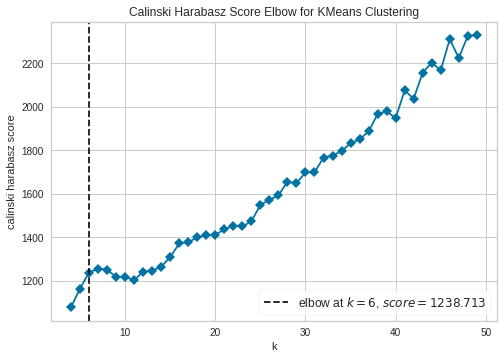

KMeans(n_clusters=49)


In [16]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,50), metric='calinski_harabasz', timings=False)

visualizer.fit(data[['time_int', 'energy']])     # Fit the data to the visualizer
visualizer.show()                                # Finalize and render the figure

print(model)

In [17]:
km = KMeans(n_clusters=6)
y_predicted = km.fit_predict(data[['time_int', 'energy']])
data['cluster']=y_predicted
data.head()

,time,energy,temperatureMax,time_int,cluster
0,2013-01-01,0.639780,7.49,0.000000,0
1,2013-01-02,0.617075,10.82,0.000887,0
2,2013-01-03,0.525869,11.41,0.001773,5
3,2013-01-04,0.523385,10.79,0.002660,5
4,2013-01-05,0.613247,10.66,0.003546,0


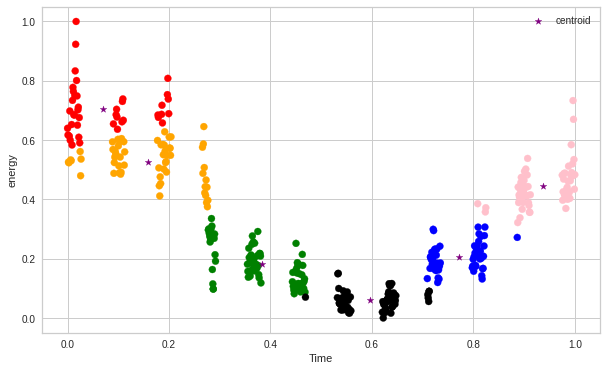

In [18]:
fig, ax = plt.subplots(figsize =(10, 6))

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(data['time_int'], data['energy'], c=data["cluster"].apply(lambda x: colors[x]))
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

In [19]:
nbs = NearestNeighbors()
nbs.fit(data[['time_int', 'energy']])

NearestNeighbors()

In [20]:
distances, indexes = nbs.kneighbors(data[['time_int', 'energy']])
print(data)

          time    energy  temperatureMax  time_int  cluster
0   2013-01-01  0.639780            7.49  0.000000        0
1   2013-01-02  0.617075           10.82  0.000887        0
2   2013-01-03  0.525869           11.41  0.001773        5
3   2013-01-04  0.523385           10.79  0.002660        5
4   2013-01-05  0.613247           10.66  0.003546        0
..         ...       ...             ...       ...      ...
358 2013-12-25  0.733295            7.19  0.996454        3
359 2013-12-26  0.669874            7.64  0.997340        3
360 2013-12-27  0.534378           10.99  0.998227        3
361 2013-12-28  0.434234            7.81  0.999113        3
362 2013-12-29  0.483188            7.56  1.000000        3

[363 rows x 5 columns]


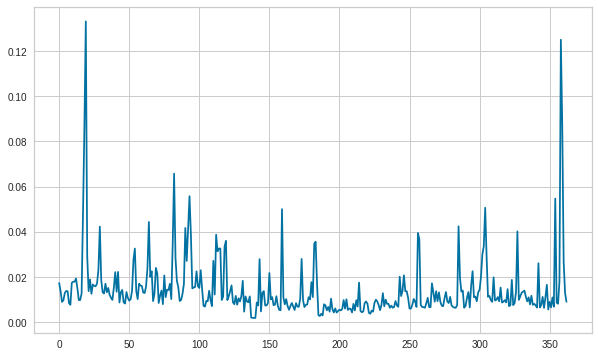

In [21]:
fig = plt.subplots(figsize =(10, 6))
plt.plot(distances.mean(axis=1))

In [22]:
anb_index = np.where(distances.mean(axis=1) > 0.05)
print(anb_index[0])

[ 18  19  82  93 159 304 354 358 359]


Text(0, 0.5, 'energy')

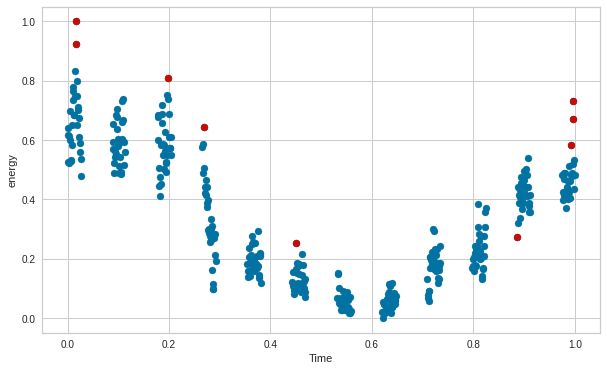

In [23]:
fig = plt.subplots(figsize =(10, 6))
plt.scatter(data['time_int'], data['energy'])
#plt.scatter(data['time_int'], distances, edgecolors='r')
plt.scatter(data['time_int'][anb_index[0]], data['energy'][anb_index[0]], color='r')
plt.xlabel('Time')
plt.ylabel('energy')